Written by Zain Kamal in March 2024 for the Python package `redplanet` (https://github.com/Humboldt-Penguin/redplanet). Feel free to contact me with questions: [zain.eris.kamal@rutgers.edu](mailto:zain.eris.kamal@rutgers.edu).

...

Purpose is to convert a 463m MOLA DEM (linked below) to `zarr.storage.ZipStore` format.
- https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m

---
---
# README

In [1]:
readme_text = '''README for `Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected.zarr.zip`

Created by Zain Kamal in March 2024 for the Python package `redplanet` (https://github.com/Humboldt-Penguin/redplanet). Feel free to contact zain.eris.kamal@rutgers.edu with questions. 

NOTE: YOU DO NOT NEED TO UNZIP A `.zarr.zip` FILE TO ACCESS THE DATA — the original zipped file is perfectly usable on its own, and unzipping will just take up more space on your computer. If you're curious about the reasoning, read the bullet points below. 
    - One of the storage classes for Zarr arrays/groups is a `zarr.storage.ZipStore` (https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.ZipStore) which does NOT compress files by default (you can verify this for yourself by unzipping and comparing file sizes). This is very similar to how '.tar' files work, if you're familiar. 
    - We use zipstores because (1) `redplanet` downloads data with `pooch.retrieve` which can only download one file at a time and must always keep the zipped version, and (2) accessing zipstores for a dataset of this size/type/structure has near-zero performance impact compared to a normal Zarr directory. 

Original data source: https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m

See link below for code used to generate this dataset (if link is broken, search the `redplanet` repo for a file called 'generate_DEM-463m_zarr-zipstore.ipynb'):
    https://github.com/Humboldt-Penguin/redplanet/blob/main/docs/development/public/Crust/generate_DEM-463m_zarr-zipstore.ipynb

We modify the original DEM by reprojecting to CRS 'Mars_2000_(Sphere)' (WKT pulled directly from USGS's 200m DEM), chunking with `dask`, and saving as a Zarr ZipStore. Primary benefits are reducing file size from 2GB to 1GB, decreasing memory usage, and significantly increasing load/access speeds (by several orders of magnitude, especially since reprojecting takes ~30 seconds every time). 


To load this dataset, use the following code:

    ```python

    import xarray as xr
    import rioxarray    ## optional to attribute/use CRS info -- if you remove this, also remove the `rio.write_crs` lines below.

    dat_dem_xr = xr.open_zarr('Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected.zarr.zip')  ## specify path as necessary

    ## Note that `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable ('Mars_MGS_MOLA_DEM_463m_v2') is the desired DEM data, and the second data variable ('spatial_ref') is the CRS info from reprojection. We want our final data as an `xarray.DataArray`, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
    dat_dem_xr = (
        dat_dem_xr
        .Mars_MGS_MOLA_DEM_463m_v2
        .rio.write_crs(
            dat_dem_xr.spatial_ref.crs_wkt
        )
    )

    _ = dat_dem_xr.attrs.pop('grid_mapping', None)

    ```
'''

---
---
# [0] Setup

In [2]:
from redplanet import utils

from pathlib import Path
import zipfile

import pooch

import numpy as np
# import pandas as pd
# import pyshtools as pysh

import xarray as xr
import rioxarray
import zarr
# import dask


---
---
# [1] Make Zarr Zipstore

<font color='red'>SEE FOOTNOTES 1 & 2</font>

In [3]:
''' ———— Input DEM path (default is to download, use local if you want) ———— '''

with utils.disable_pooch_logger():
    fpath_dem_tif = pooch.retrieve(
        fname      = 'Mars_MGS_MOLA_DEM_mosaic_global_463m.tif', 
        url        = r'https://drive.google.com/file/d/1ACMocVNzs7pFwxulLOp2vqQ24LjLOVuU/view?usp=sharing',     ## google drive mirror, use usgs if you want.
        # known_hash = 'sha256:38a4eb0b4452855b8dabfac40a367b458555ab4c01b31235807ad0a53c031f4c', 
        known_hash = 'xxh3_64:a0dc027e687f855f',    ## use sha256 if xxh3 not installed, it just takes longer.
        # known_hash = None, 
        path       = pooch.os_cache('redplanet') / 'Crust' / 'topo', 
        downloader = utils.download_gdrive_file_SHOWPROGRESS, 
    )


fpath_dem_tif = Path(fpath_dem_tif) ## customize this if you want



''' —————————————— Load DEM (chunked with dask) and reproject —————————————— '''

# Mars 2000 Sphere CRS, directly taken from the 200m DEM file.
target_crs_wkt = 'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'

dat_dem_xr = (
    rioxarray.open_rasterio(
        filename = fpath_dem_tif, 
        chunks   = {'x': 'auto', 'y': 'auto'}, 
    )
    .rio.reproject(target_crs_wkt)      ## bottleneck (~45sec)
    .chunk({'x': 'auto', 'y': 'auto'})
    .sel(band=1).drop_vars(['band'])
    .rename({'x': 'lon', 'y': 'lat'})
    .sortby('lat', ascending=True)
    .chunk({'lon': 'auto', 'lat': 'auto'})
    .rename('Mars_MGS_MOLA_DEM_463m_v2')
)

dat_dem_xr.attrs = {
    'units'    : 'meters', 
    'metadata' : {
        'source_data' : 'https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m', 
        'source_code' : 'https://github.com/Humboldt-Penguin/redplanet/blob/main/docs/development/public/Crust/generate_DEM-463m_zarr-zipstore.ipynb', 
        'description' : "For description of modifications and source code, see the source code or 'Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected.zarr/_README.txt' (you can open the file without unzipping everything)."
    },  
}

print(f'New CRS info:\n')
utils.print_dict(dat_dem_xr.spatial_ref.attrs)
print()
print(f'xarray.DataArray string repr:\n{dat_dem_xr}')
print()
print(f'xarray.DataArray html repr (may not fully render in Github):\n')
dat_dem_xr

New CRS info:

'crs_wkt'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'semi_major_axis'
	3396190.0
'semi_minor_axis'
	3396190.0
'inverse_flattening'
	0.0
'reference_ellipsoid_name'
	'Mars_2000_Sphere_IAU_IAG'
'longitude_of_prime_meridian'
	0.0
'prime_meridian_name'
	'Reference_Meridian'
'geographic_crs_name'
	'GCS_Mars_2000_Sphere'
'horizontal_datum_name'
	'Mars_2000_(Sphere)'
'grid_mapping_name'
	'latitude_longitude'
'spatial_ref'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'GeoTransform'
	'-180.0 0.007812330461578525 0.0 90.0 0.0 -0.007812060044947162'

xarray.DataArray string repr:
<xarray

<xarray.DataArray 'Mars_MGS_MOLA_DEM_463m_v2' (lat: 23041, lon: 46081)> Size: 2GB
dask.array<rechunk-merge, shape=(23041, 46081), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 369kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 184kB -89.99 -89.99 -89.98 ... 89.98 89.99 90.0
    spatial_ref  int32 4B 0
Attributes:
    units:     meters
    metadata:  {'source_data': 'https://astrogeology.usgs.gov/search/map/Mars...

In [4]:
''' ———————————————————— Write Zarr ZipStore and README ———————————————————— '''

fpath_dem_zarrzip = pooch.os_cache('redplanet') / 'Crust' / 'topo' / 'Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected.zarr.zip'

with zarr.ZipStore(fpath_dem_zarrzip, mode='w') as zipstore:
    dat_dem_xr.to_zarr(store=zipstore)

with zipfile.ZipFile(fpath_dem_zarrzip, 'a') as zipf:
    zipf.writestr('_README.txt', readme_text)


In [5]:
''' ——————————————————————————— hashes for pooch ——————————————————————————— '''

print(f"xxh3_64:{pooch.file_hash(fpath_dem_zarrzip, alg='xxh3_64')}")
print(f"sha256:{ pooch.file_hash(fpath_dem_zarrzip, alg='sha256' )}")
print(f"md5:{    pooch.file_hash(fpath_dem_zarrzip, alg='md5'    )}")

xxh3_64:84e93b12f71fc7d2
sha256:c60bf1ee895ce88b537ef9911075e783b10337cb2ce57ba20b93701b785c27e2
md5:8be196eeaf773df44236da935f75de6a


Proper hashes:
- xxh3_64:84e93b12f71fc7d2
- sha256:c60bf1ee895ce88b537ef9911075e783b10337cb2ce57ba20b93701b785c27e2
- md5:8be196eeaf773df44236da935f75de6a

---
---
# [2] Verify

In [6]:
''' ———————————————————————————— load to xarray ———————————————————————————— '''

fpath_dem_zarrzip = pooch.os_cache('redplanet') / 'Crust' / 'topo' / 'Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected.zarr.zip'

dat_dem_xr = xr.open_zarr(fpath_dem_zarrzip)

## The following line is needed since `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable 'Mars_MGS_MOLA_DEM_463m_v2' is the desired DEM data, but the other data variable 'spatial_ref' is the CRS info from reprojection. We want our final data as an `xarray.DataArray` for convenience, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
dat_dem_xr = (
    dat_dem_xr
    .Mars_MGS_MOLA_DEM_463m_v2
    .rio.write_crs(
        dat_dem_xr.spatial_ref.crs_wkt
    )
)

_ = dat_dem_xr.attrs.pop('grid_mapping', None)

dat_dem_xr

<xarray.DataArray 'Mars_MGS_MOLA_DEM_463m_v2' (lat: 23041, lon: 46081)> Size: 2GB
dask.array<open_dataset-Mars_MGS_MOLA_DEM_463m_v2, shape=(23041, 46081), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 184kB -89.99 -89.99 -89.98 ... 89.98 89.99 90.0
  * lon          (lon) float64 369kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    spatial_ref  int32 4B 0
Attributes:
    metadata:  {'description': "For description of modifications and source c...
    units:     meters

region.mean().values.item() = -720.5879141384048
region.values.shape = (23041, 46081)


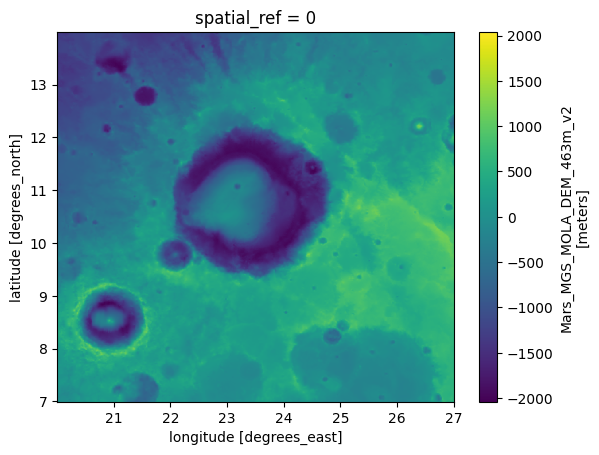

In [7]:
''' —————————————————————————————— test access ————————————————————————————— '''

lon_bounds = (-180, 180)
lat_bounds = (-90, 90)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


print(f'{region.mean().values.item() = }')
print(f'{region.values.shape = }')





''' ——————————————————————————————— test plot —————————————————————————————— '''

lon_bounds = (20, 27)
lat_bounds = (7, 14)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


region.plot.imshow(cmap='viridis')

---
---
---
# † FOOTNOTES

---
## [Footnote 1] — Reprojection CRS

When reprojecting the 463m DEM (since native units are x and y in meters I think), we use the CRS WKT straight from the 200m DEM file (stored in the `target_crs_wkt` variable, in case you (a) want to reproject without downloading the entire 200m file, (b) don't see an incentive for me to lie about this /or/ trust that I wouldn't lie, and (c) trust I can copy-paste text properly).

<!-- &nbsp; -->

...

<!-- &nbsp; -->

Main CRS attrs for each DEM (straight from the TIF downloaded from USGS):
- 200m DEM (https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp):
    - 'GeoTransform'
        - '-180.0 0.003374120830641 0.0 90.0 0.0 -0.003374120830641'
    - 'crs_wkt'
        - 'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
- 463m DEM (https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2)
    - 'GeoTransform'
        - '-10669675.197320545 463.0935415503709 0.0 5334837.598660273 0.0 -463.0935415503709'
    - 'crs_wkt'
        - 'PROJCS["Equirectangular Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars_localRadius",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

---
## [Footnote 2] — Alternative reprojection method with `rasterio` WarpedVRT

Note: when it comes to reprojecting the 463m DEM, here's another code implementation that yields identical results and loads instantly (although I assume speed is lost when calculations are done on the fly). The code is pretty rough (and probably missing some things), but should be fairly easy to adapt if the need arises.

&nbsp;

```python
import rasterio

target_crs_wkt = 'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'

# vrt = rasterio.vrt.WarpedVRT(rasterio.open(custom_DEM_fpath), crs=target_crs_wkt)
dat_dem_xr_v1 = (
    rioxarray.open_rasterio(
        filename = rasterio.vrt.WarpedVRT(
            src_dataset = rasterio.open(fpath_custom_DEM), 
            crs         = target_crs_wkt, 
        ), 
        chunks = {'x': 'auto', 'y': 'auto'}, 
    )
    .sel(band=1).drop_vars(['band', 'spatial_ref'])
    .rename({'x': 'lon', 'y': 'lat'})
    .sortby('lat', ascending=True)
)


dat_dem_xr_v1
```